# Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib keras

In [4]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow import keras
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# 1. Data Preprocessing for CNN Model (Done by Loh Le Zhou)

## Load Data, extract labels, resizing with aspect ratio and normalization

In [27]:
# Function to resize an image with aspect ratio preservation
def preprocess_image(image, target_size=(64, 64)):
    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the aspect ratio of the original image
    aspect_ratio = original_width / original_height

    # Calculate new dimensions while maintaining aspect ratio
    target_width, target_height = target_size
    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image using bilinear interpolation to maintain colors
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Create an empty canvas of the target size
    canvas = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width, :] = resized_image
    
    # Convert the canvas back to BGR color space
    canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
    
    # Normalize pixel values to the range [0, 1]
    normalized_image = canvas_bgr / 255.0
    
    return normalized_image

In [93]:
# Read lines from the file
with open('Annotation.txt', 'r') as file:
    lines = file.readlines()

# Load and preprocess the dataset
processed_images = []
labels = []

for line in lines:
    data = line.strip().split(';')
    filename = data[0]
    class_label = int(data[7])  # Assuming class label is the last element

    # Construct the image path
    image_path = 'C:\\Users\\lezho\\mini project\\Dataset\\tsrd-train\\' + filename

    image = cv2.imread(image_path)
    processed_image = preprocess_image(image)
    processed_images.append(processed_image)
    labels.append(class_label)

# Convert the lists to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((processed_images, labels))

In [4]:
processed_image

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.20392157, 0.27058824, 0.14117647],
        [0.19215686, 0.25098039, 0.14117647],
        [0.58823529, 0.61960784, 0.56470588],
        ...,
        [0.17647059, 0.21960784, 0.14509804],
        [0.18823529, 0.21568627, 0.15294118],
        [0.20392157, 0.21960784, 0.16862745]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

## Load random images

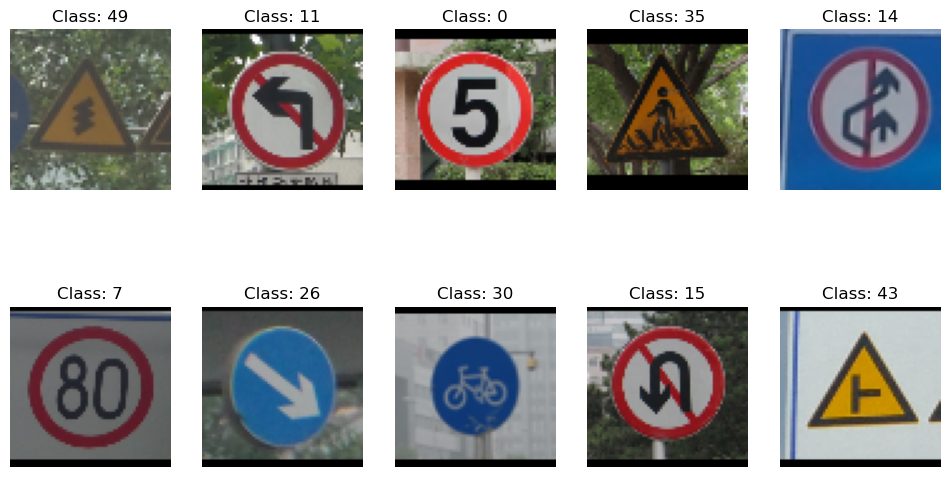

In [34]:
import random
import matplotlib.pyplot as plt

# Convert the TensorFlow dataset to a NumPy array
dataset = list(dataset.as_numpy_iterator())

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots

# Show 10 random images with their corresponding labels
for i in range(2):
    for j in range(5):
        # Randomly select an image and label
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]

        # Display the image in the current subplot
        axes[i, j].imshow(image)
        axes[i, j].set_title("Class: " + str(label))
        axes[i, j].axis("off")

plt.show()

## Load images from a class

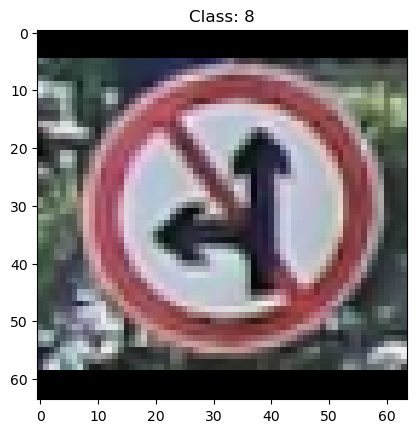

In [98]:
# Choose the class you want to visualize (replace with your desired class label)
desired_class = 8

# Filter the dataset to include only images from the desired class
class_dataset = dataset.filter(lambda image, label: label == desired_class)

# Shuffle the filtered dataset
class_dataset = class_dataset.shuffle(buffer_size=len(lines))

# Take a batch of 10 random samples from the filtered and shuffled dataset
batch = class_dataset.take(10).as_numpy_iterator()

# Show each image in the batch
for image, label in batch:
    plt.imshow(image)
    plt.title("Class: " + str(label))
    plt.axis("on")  # Turn off axis ticks and labels
    plt.show()

## Class distribution before data augmentation

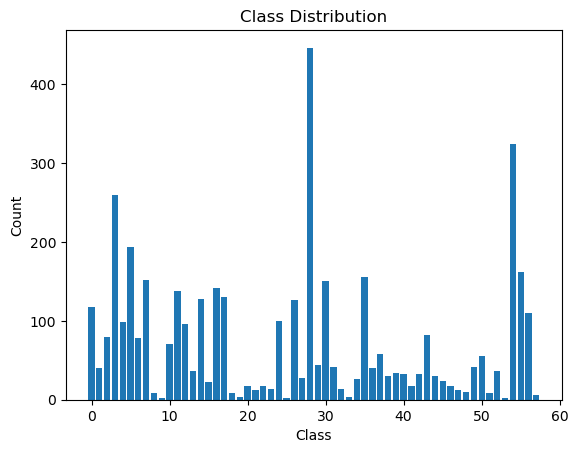

In [7]:
# Convert the labels dataset to a NumPy array and ensure it's of integer data type
labels_array = np.array(list(dataset.map(lambda image, label: label).as_numpy_iterator()), dtype=np.int32)

# Count the occurrences of each class
class_counts = np.bincount(labels_array)

# Plot the class distribution
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [8]:
# Convert the labels dataset to a NumPy array and ensure it's of integer data type
labels_array = np.array(list(dataset.map(lambda image, label: label).as_numpy_iterator()), dtype=np.int32)

# Count the occurrences of each class
class_counts = np.bincount(labels_array)

# Display the class distribution
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: Count = {count}")

Class 0: Count = 118
Class 1: Count = 40
Class 2: Count = 80
Class 3: Count = 260
Class 4: Count = 98
Class 5: Count = 194
Class 6: Count = 78
Class 7: Count = 152
Class 8: Count = 8
Class 9: Count = 2
Class 10: Count = 70
Class 11: Count = 138
Class 12: Count = 96
Class 13: Count = 36
Class 14: Count = 128
Class 15: Count = 22
Class 16: Count = 142
Class 17: Count = 130
Class 18: Count = 8
Class 19: Count = 4
Class 20: Count = 18
Class 21: Count = 12
Class 22: Count = 18
Class 23: Count = 14
Class 24: Count = 100
Class 25: Count = 2
Class 26: Count = 126
Class 27: Count = 28
Class 28: Count = 446
Class 29: Count = 44
Class 30: Count = 150
Class 31: Count = 42
Class 32: Count = 14
Class 33: Count = 4
Class 34: Count = 26
Class 35: Count = 156
Class 36: Count = 40
Class 37: Count = 58
Class 38: Count = 30
Class 39: Count = 34
Class 40: Count = 32
Class 41: Count = 18
Class 42: Count = 32
Class 43: Count = 82
Class 44: Count = 30
Class 45: Count = 24
Class 46: Count = 18
Class 47: Count 

# 2. Data Augmentation (Done by Loh Le Zhou)

In [35]:
import tensorflow as tf

def augment(image, seed, target_size=(64, 64)):
    rng = tf.random.Generator.from_seed(seed, alg='philox')
    
    # Randomly adjust brightness and contrast
    image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=rng.make_seeds(2)[0])
    image = tf.image.stateless_random_contrast(image, lower=0.4, upper=0.9, seed=rng.make_seeds(2)[0])

    # Randomly adjust hue and saturation
    image = tf.image.stateless_random_hue(image, max_delta=0.2, seed=rng.make_seeds(2)[0])
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=70, max_jpeg_quality=90, seed=rng.make_seeds(2)[0])
    image = tf.image.stateless_random_saturation(image, lower=0.5, upper=1.5, seed=rng.make_seeds(2)[0])

    # Ensure pixel values are in the [0, 1] range.
    image = tf.clip_by_value(image, 0, 1)
    
    return image

In [36]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with your desired augmentation parameters
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [38]:
# Read lines from the file
with open('Annotation.txt', 'r') as file:
    lines = file.readlines()

# Count occurrences of each class
class_counts = {}
for line in lines:
    data = line.strip().split(';')
    class_label = int(data[7])
    if class_label in class_counts:
        class_counts[class_label] += 1
    else:
        class_counts[class_label] = 1

# Loop through all class labels
for class_label, count in class_counts.items():
    # Gather all images from the same class
    class_images = [processed_images[i] for i in range(len(processed_images)) if labels[i] == class_label]
    
    # Perform data augmentation until the desired threshold is reached
    while count < 1100:
        for image in class_images:
            seed = (class_label, count)
            augmented_image = datagen.random_transform(image)
            augmented_image = augment(augmented_image, seed)
            processed_images.append(augmented_image)
            labels.append(class_label)
            count += 1
            
# Convert the lists to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((processed_images, labels))

## show augmented data

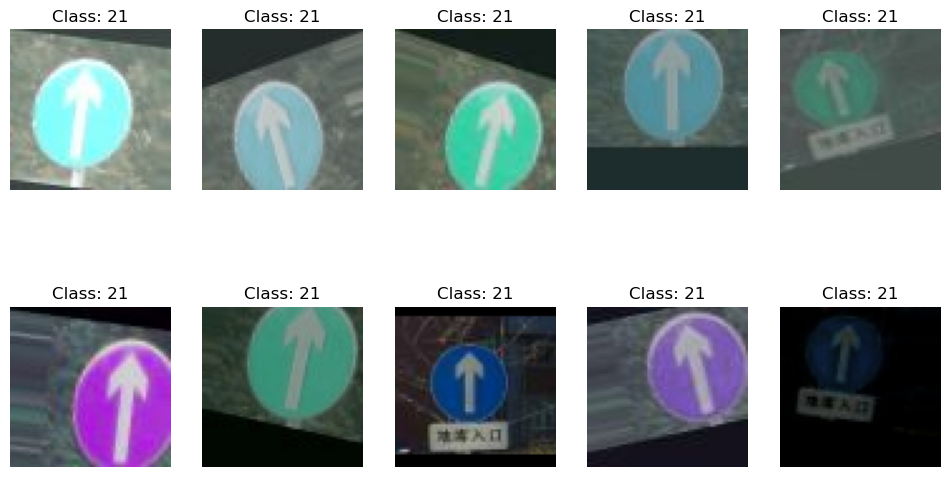

In [58]:
import matplotlib.pyplot as plt
import math

# Choose the class you want to visualize
desired_class = 21

# Filter the dataset to include only images from the desired class
class_dataset = dataset.filter(lambda image, label: label == desired_class)

# Shuffle the filtered dataset
class_dataset = class_dataset.shuffle(buffer_size=len(lines))

# Take a batch of 10 random samples from the filtered and shuffled dataset
batch = class_dataset.take(10).as_numpy_iterator()

# Calculate the number of rows and columns for the subplots
num_rows = 2
num_cols = 5

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

# Show each image in the batch
for i, (image, label) in enumerate(batch):
    row = i // num_cols
    col = i % num_cols

    axes[row, col].imshow(image)
    axes[row, col].set_title("Class: " + str(label))
    axes[row, col].axis("off")  # Turn off axis ticks and labels

plt.show()

## Class distribution after data augmentation

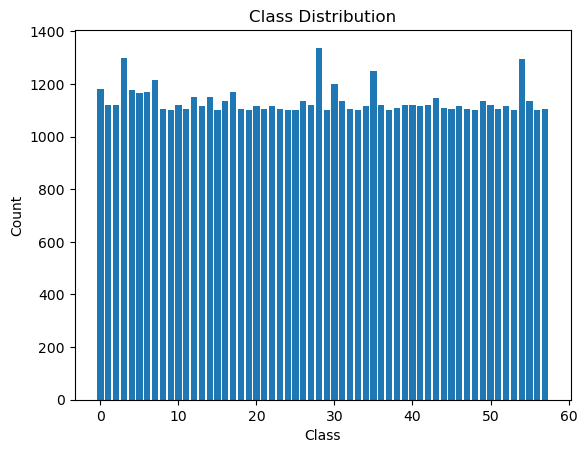

In [14]:
# Convert the labels dataset to a NumPy array and ensure it's of integer data type
labels_array = np.array(list(dataset.map(lambda image, label: label).as_numpy_iterator()), dtype=np.int32)

# Count the occurrences of each class
class_counts = np.bincount(labels_array)

# Plot the class distribution
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [15]:
# Convert the labels dataset to a NumPy array and ensure it's of integer data type
labels_array = np.array(list(dataset.map(lambda image, label: label).as_numpy_iterator()), dtype=np.int32)

# Count the occurrences of each class
class_counts = np.bincount(labels_array)

# Display the class distribution
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: Count = {count}")

Class 0: Count = 1180
Class 1: Count = 1120
Class 2: Count = 1120
Class 3: Count = 1300
Class 4: Count = 1176
Class 5: Count = 1164
Class 6: Count = 1170
Class 7: Count = 1216
Class 8: Count = 1104
Class 9: Count = 1100
Class 10: Count = 1120
Class 11: Count = 1104
Class 12: Count = 1152
Class 13: Count = 1116
Class 14: Count = 1152
Class 15: Count = 1100
Class 16: Count = 1136
Class 17: Count = 1170
Class 18: Count = 1104
Class 19: Count = 1100
Class 20: Count = 1116
Class 21: Count = 1104
Class 22: Count = 1116
Class 23: Count = 1106
Class 24: Count = 1100
Class 25: Count = 1100
Class 26: Count = 1134
Class 27: Count = 1120
Class 28: Count = 1338
Class 29: Count = 1100
Class 30: Count = 1200
Class 31: Count = 1134
Class 32: Count = 1106
Class 33: Count = 1100
Class 34: Count = 1118
Class 35: Count = 1248
Class 36: Count = 1120
Class 37: Count = 1102
Class 38: Count = 1110
Class 39: Count = 1122
Class 40: Count = 1120
Class 41: Count = 1116
Class 42: Count = 1120
Class 43: Count = 114

# Split Data (training, validation)

In [18]:
num_samples = len(processed_images)
num_train_samples = int(0.8 * num_samples)  # 80% for training
num_val_samples = num_samples - num_train_samples  # Remaining for validation

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_samples, reshuffle_each_iteration=False)

In [19]:
# Split the dataset
train_dataset = dataset.take(num_train_samples)
val_dataset = dataset.skip(num_train_samples)

In [20]:
num_train_samples

52675

In [21]:
num_val_samples

13169

# 3. Build Deep Learning Model (Done by Loh Le Zhou)

## CNN Model

In [118]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten Layer
model.add(layers.Flatten())

# Dropout Layer
model.add(layers.Dropout(0.5))

# Dense Layer 1
model.add(layers.Dense(512, activation='relu'))

# Dense Layer 2
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(58, activation='softmax'))  # num_classes is the number of output classes

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

# 4. CNN Model Training (Done by Loh Le Zhou)

In [24]:
# Set batch size and prepare for training
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Train the model
epochs = 15
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/15
1647/1647 [==============================] - 540s 327ms/step - loss: 3.2190 - accuracy: 0.1345 - val_loss: 1.7448 - val_accuracy: 0.4852
Epoch 2/15
1647/1647 [==============================] - 526s 319ms/step - loss: 1.5592 - accuracy: 0.5205 - val_loss: 0.5670 - val_accuracy: 0.8460
Epoch 3/15
1647/1647 [==============================] - 567s 344ms/step - loss: 0.9643 - accuracy: 0.7007 - val_loss: 0.2969 - val_accuracy: 0.9207
Epoch 4/15
1647/1647 [==============================] - 482s 292ms/step - loss: 0.6999 - accuracy: 0.7811 - val_loss: 0.1641 - val_accuracy: 0.9607
Epoch 5/15
1647/1647 [==============================] - 521s 316ms/step - loss: 0.5633 - accuracy: 0.8234 - val_loss: 0.1213 - val_accuracy: 0.9693
Epoch 6/15
1647/1647 [==============================] - 519s 315ms/step - loss: 0.4627 - accuracy: 0.8551 - val_loss: 0.0962 - val_accuracy: 0.9796
Epoch 7/15
1647/1647 [==============================] - 540s 328ms/step - loss: 0.3946 - accuracy: 0.8772 - val_

# 5. Model Evaluation (Done by Loh Le Zhou)

## Plot Performance, Learning curves

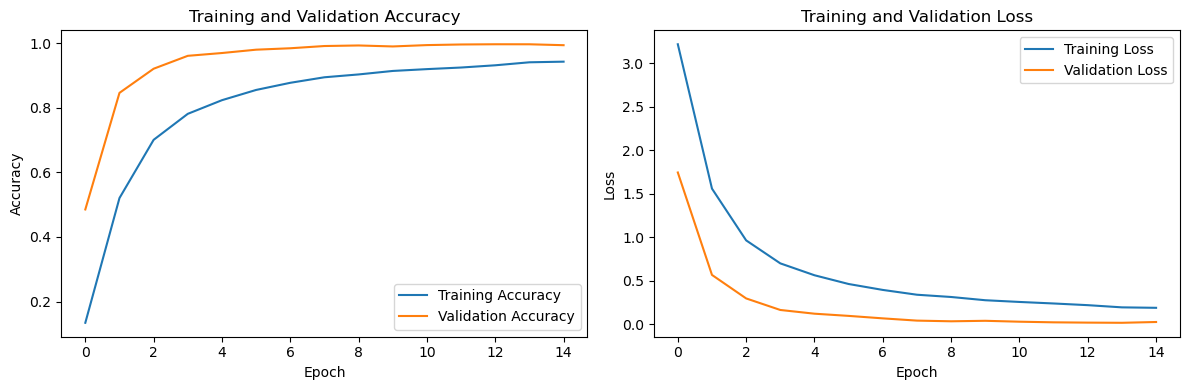

In [25]:
# Plot learning curves
plt.figure(figsize=(12, 4))

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Load test dataset

In [2]:
# Define a function to preprocess an image
def preprocess_test_image(image_path, class_label):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Adjust channels if needed
    
    # Resize the image based on the bounding box coordinates
    resized_image = tf.image.resize(image, (64, 64))
    
    # Normalize the image pixel values to [0, 1]
    normalized_image = resized_image / 255.0
    
    return normalized_image, class_label

In [100]:
# Load test dataset
# Load and preprocess the test dataset
test_processed_images = []
test_labels = []

test_lines = []  # Read lines from the test annotation file
with open('Test_Annotation.txt', 'r') as file:
    test_lines = file.readlines()

for line in test_lines:
    data = line.strip().split(';')
    filename = data[0]
    class_label = int(data[7])

    # Construct the image path for the test dataset
    image_path = 'C:\\Users\\lezho\\mini project\\Dataset\\TSRD-Test\\' + filename

    # Preprocess the image
    processed_image, label = preprocess_test_image(image_path, class_label)

    test_processed_images.append(processed_image)
    test_labels.append(label)

# Convert the test lists to TensorFlow Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_processed_images, test_labels))

In [101]:
len(test_processed_images)

2007

## Load model

In [21]:
model = tf.keras.models.load_model("C:\\Users\\lezho\\mini project\\model1")

## Model evaluation on test dataset

In [102]:
from sklearn.metrics import precision_score, recall_score

# Evaluate the model on the test dataset
results = model.evaluate(test_dataset.batch(batch_size=32))

63/63 [==============================] - 10s 163ms/step - loss: 0.4630 - accuracy: 0.9417


## Precision, Recall, F1 Score

In [103]:
# Create lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through all test images
for i in range(len(test_processed_images)):
    image = test_processed_images[i]
    label = test_labels[i]
    
    # Make predictions using the model
    predictions = model.predict(tf.expand_dims(image, axis=0),verbose=0)
    predicted_label = tf.argmax(predictions[0]).numpy()
    
    true_labels.append(label)
    predicted_labels.append(predicted_label)

# Convert lists to numpy arrays for easier calculation of metrics
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and F1-score using sklearn metrics
precision = precision_score(true_labels, predicted_labels,average='macro')
recall = recall_score(true_labels, predicted_labels,average='macro')
f1 = f1_score(true_labels, predicted_labels,average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8882291987540225
Recall: 0.89798374747431
F1-score: 0.8752109239810635


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification report

In [104]:
from sklearn.metrics import classification_report

# Generate a classification report for additional metrics
class_report = classification_report(true_labels, predicted_labels)
print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       1.00      0.83      0.91        12
           2       0.97      1.00      0.98        60
           3       0.98      1.00      0.99        84
           4       0.91      1.00      0.95        58
           5       0.72      0.88      0.79        50
           6       0.97      1.00      0.98        30
           7       0.95      0.72      0.82        50
           8       1.00      1.00      1.00        14
           9       0.00      0.00      0.00         3
          10       1.00      1.00      1.00        60
          11       1.00      0.97      0.98       130
          12       0.85      1.00      0.92        22
          13       1.00      0.91      0.95        92
          14       1.00      0.83      0.91        12
          15       0.97      0.94      0.96        36
          16       1.00      1.00      1.00        76
          17       1.00    

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

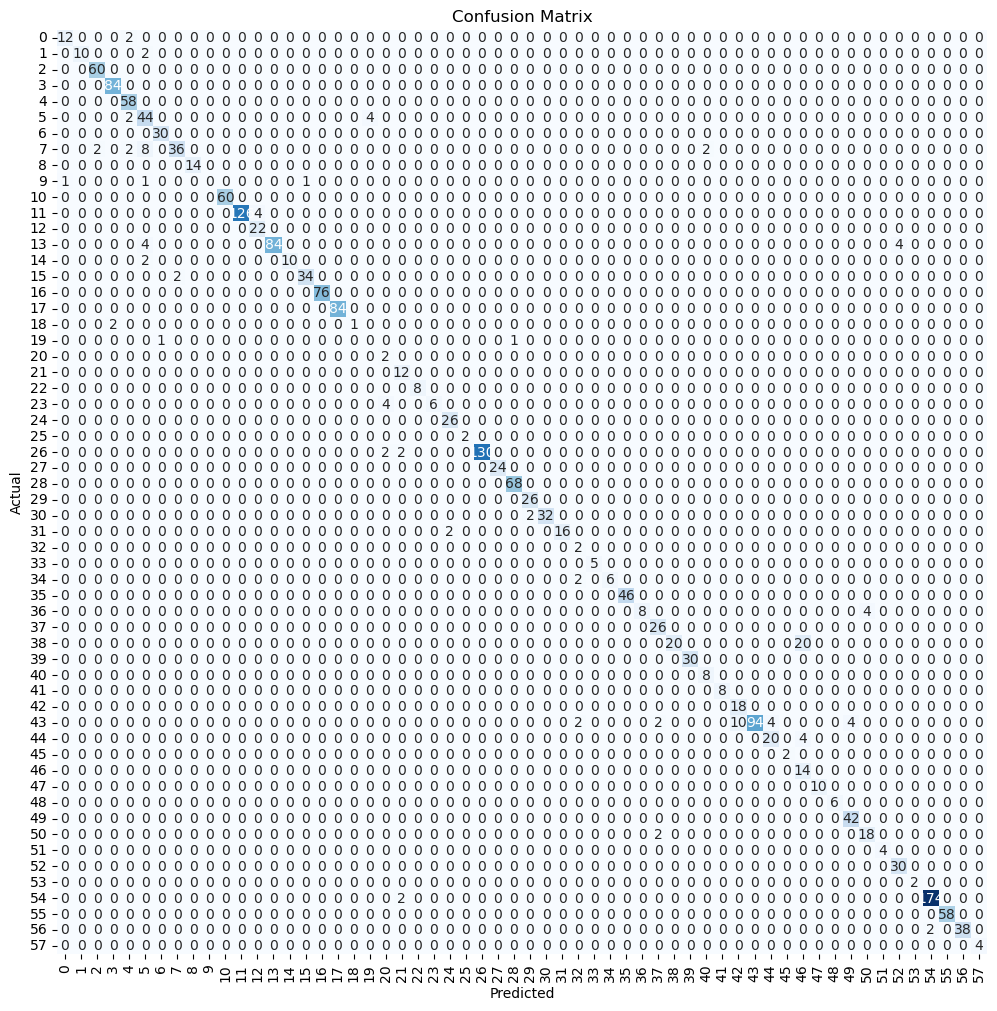

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Replace 'true_labels' and 'predicted_labels' with your actual labels
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Extract information from confusion matrix

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get class labels
classes = unique_labels(true_labels, predicted_labels)

# Sort the predictions within each true class from most to least frequent
for i, true_class in enumerate(classes):
    row = ''
    sorted_indices = np.argsort(cm[i])[::-1]  # Sort predicted classes within this true class
    for j in sorted_indices:
        count = cm[i][j]
        if count > 0:
            if row:
                row += ', '
            row += f'{count} (class {classes[j]})'
    if row:
        print(f'class {true_class} : {row}')

    # Sort the confusion matrix for this true class accordingly
    cm[i] = cm[i][sorted_indices]

class 0 : 12 (class 0), 2 (class 4)
class 1 : 10 (class 1), 2 (class 5)
class 2 : 60 (class 2)
class 3 : 84 (class 3)
class 4 : 58 (class 4)
class 5 : 44 (class 5), 4 (class 19), 2 (class 4)
class 6 : 30 (class 6)
class 7 : 36 (class 7), 8 (class 5), 2 (class 40), 2 (class 2), 2 (class 4)
class 8 : 14 (class 8)
class 9 : 1 (class 0), 1 (class 5), 1 (class 15)
class 10 : 60 (class 10)
class 11 : 126 (class 11), 4 (class 12)
class 12 : 22 (class 12)
class 13 : 84 (class 13), 4 (class 52), 4 (class 5)
class 14 : 10 (class 14), 2 (class 5)
class 15 : 34 (class 15), 2 (class 7)
class 16 : 76 (class 16)
class 17 : 84 (class 17)
class 18 : 2 (class 3), 1 (class 18)
class 19 : 1 (class 28), 1 (class 6)
class 20 : 2 (class 20)
class 21 : 12 (class 21)
class 22 : 8 (class 22)
class 23 : 6 (class 23), 4 (class 20)
class 24 : 26 (class 24)
class 25 : 2 (class 25)
class 26 : 130 (class 26), 2 (class 21), 2 (class 20)
class 27 : 24 (class 27)
class 28 : 68 (class 28)
class 29 : 26 (class 29)
class 3

## Predicted and true labels from classes selected

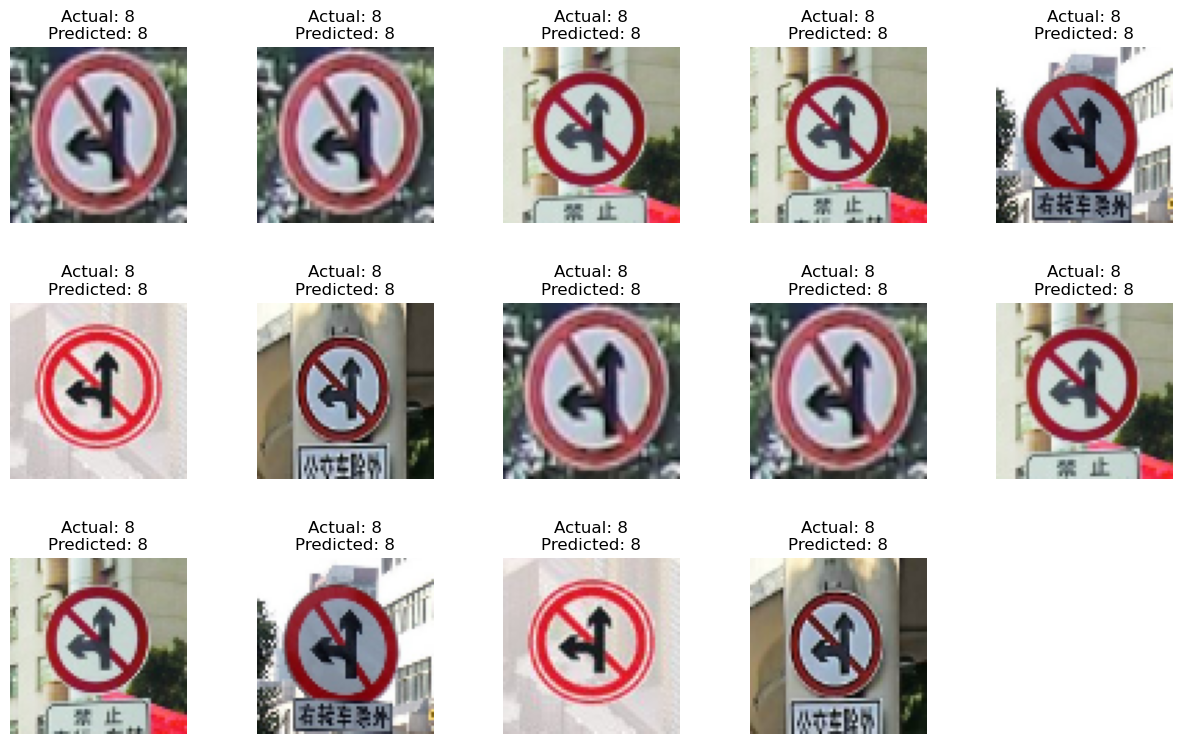

In [92]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the maximum number of images to display in a row
images_per_row = 5

# SELECT THE CLASSES HERE
# Define the list of class labels to display (e.g., classes 0, 1, 2, 3, 4)
selected_classes = [8]

# Loop through the selected classes
for selected_class in selected_classes:
    # Find indices of images in the selected class
    class_indices = [i for i, label in enumerate(test_labels) if label == selected_class]

    if not class_indices:
        print(f"No images found for class {selected_class}")
    else:
        # Calculate the number of rows needed to display all images
        num_rows = (len(class_indices) - 1) // images_per_row + 1

        # Create subplots for displaying images in rows and columns
        plt.figure(figsize=(15, 3 * num_rows))
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        for i, random_index in enumerate(class_indices):
            # Get the image and label using the selected index
            selected_image = test_processed_images[random_index]
            selected_label = test_labels[random_index]

            # Make predictions using the model without the progress bar
            predictions = model.predict(tf.expand_dims(selected_image, axis=0), verbose=0)
            predicted_label = tf.argmax(predictions[0]).numpy()

            # Display the image with the class label
            plt.subplot(num_rows, images_per_row, i + 1)
            plt.imshow(selected_image)
            plt.title(f"Actual: {selected_label}\nPredicted: {predicted_label}")
            plt.axis('off')  # Turn off axis labels

        # Show the row of images for the current class
        plt.show()

## Save the Model

In [ ]:
model.save('C:\\Users\\lezho\\mini project\\model1')

# 6. GUI for Model (Done by Loh Le Zhou)
The graphical user interface (GUI) code for traffic sign recognition was adapted from an article written by Shikha Gupta, titled "Traffic Signs Recognition using CNN and Keras in Python." The article was published on Analytics Vidhya on December 21, 2021, and last modified on July 26th, 2023. The code can be found in the article at the following URL:
[Link to the Original Article](https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/)

In [157]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
# Load the trained model to classify signs
from keras.models import load_model

# Load your model here; replace 'model_path' with the path to your model file
model = load_model('C:\\Users\\lezho\\mini project\\model1')

# Define your class labels
classes = { 0:'Speed limit (5km/h)',
           1:'Speed limit (15km/h)',
           2:'Speed limit (30km/h)',
           3:'Speed limit (40km/h)',
           4:'Speed limit (50km/h)',
           5:'Speed limit (60km/h)',
           6:'Speed limit (70km/h)',
           7:'Speed limit (80km/h)',
           8:'No Straight Through/Left', 
           9:'No Straight Through/Right',
           10:'No Straight Through',
           11:'No Left Turn',
           12:'No Left/Right Turn',
           13:'No right Turn',
           14:'No Overtaking',
           15:'No U-Turn',
           16:'No Vehicles',
           17:'No-Honking',
           18:'End Maximum Speed limit (40km/h)',
           19:'End Maximum Speed limit (50km/h)',
           20:'Dangerous curve to the right',
           21:'One Way',
           22:'Turn Left ahead',
           23:'Turn Left/Right',
           24:'Turn right ahead',
           25:'Keep Left',
           26:'Keep Right',
           27:'Roundabout',
           28:'Mandatory lane for cars',
           29:'Honking Mandatory',
           30:'Cyclist path',
           31:'U-Turn',
           32:'Obstacle Warning',
           33:'Traffic Light Ahead',
           34:'Cars Not Allowed',
           35:'Pedestrain Crossing',
           36:'Cyclist Warning',
           37:'Child Warning',
           38:'Road Right Bend',
           39:'Road Left Bend',
           40:'Steep Descent Ahead',
           41:'Steep Ascent  Ahead',
           42:'Caution High Voltage',
           43:'Uncontrolled Crossroad from Right Warning',
           44:'Uncontrolled Crossroad from Left Warning',
           45:'Housing Area',
           46:'Double Curve Ahead Warning',
           47:'Rail Crossing',
           48:'Road Works Ahead',
           49:'Dangerous Road Bends',
           50:'Railway Crossing Ahead',
           51:'Rear End Collision',
           52:'Stop Sign',
           53:'No Vehicles Entry',
           54:'No parking',
           55:'No Entry',
           56:'Yield',
           57:'Do not Enter'}

# Initialize GUI
top = tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')

label = Label(top, background='#CDCDCD', font=('arial', 15, 'bold'))
sign_image = Label(top)

def classify(file_path):
    image = Image.open(file_path)
    # Resize the image to the shape expected by your model (64x64 pixels)
    image = image.resize((64, 64))
    image = np.expand_dims(image, axis=0)
    image = np.array(image) / 255.0  # Normalize the pixel values
    pred_probabilities = model.predict(image)
    pred_class = np.argmax(pred_probabilities)
    sign = classes.get(pred_class, 'Unknown')
    print(sign)
    label.configure(foreground='#011638', text=sign)

def show_classify_button(file_path):
    classify_b = Button(top, text="Classify Image", command=lambda: classify(file_path), padx=10, pady=5)
    classify_b.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
    classify_b.place(relx=0.79, rely=0.46)

def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width() / 2.25), (top.winfo_height() / 2.25)))
        im = ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image = im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload = Button(top, text="Upload an image", command=upload_image, padx=10, pady=5)
upload.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
upload.pack(side=BOTTOM, pady=50)
sign_image.pack(side=BOTTOM, expand=True)
label.pack(side=BOTTOM, expand=True)
heading = Label(top, text="Traffic Sign Classification", pady=20, font=('arial', 20, 'bold'))
heading.configure(background='#CDCDCD', foreground='#364156')
heading.pack()
top.mainloop()

1/1 [==============================] - 0s 157ms/step
Speed limit (30km/h)
